# Paramak to OpenMC (DAGMC) Workflow

This notebook walks through the full pipeline of:
1.  Creating a `paramak` reactor model.
2.  Converting the CAD model to a DAGMC `.h5m` file.
3.  Defining `openmc` materials, geometry, and settings.
4.  Plotting the DAGMC geometry in OpenMC.
5.  Running the OpenMC simulation.

## Step 0: Setup and Imports

In [4]:
import openmc
import openmc.plotter
import paramak
from cad_to_dagmc import CadToDagmc
from pathlib import Path
from IPython.display import Image, display # For displaying plots

# --- Step 0: Setup ---
# Set path for cross-sections.
openmc.config['cross_sections'] = Path.home() / 'nuclear_data' / 'cross_sections.xml'
print(f"Set openmc.config['cross_sections'] to {openmc.config['cross_sections']}")

# --- NEW: Define and create the output directory ---
output_dir = Path.cwd().parent / "outputs"
print(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"All outputs will be saved to: {output_dir}")

Set openmc.config['cross_sections'] to /home/vk/nuclear_data/cross_sections.xml
/home/vk/fusion-neutronics-modelling/outputs
All outputs will be saved to: /home/vk/fusion-neutronics-modelling/outputs


## Step 1: Create Paramak Model

A 180-degree sector model is created. The `radial_build_list` and `vertical_build_list` are defined to control the reactor's composition.

In [ ]:
print("Creating Paramak model...")

radial_build_list = [
    (paramak.LayerType.GAP, 10),
    (paramak.LayerType.SOLID, 30),
    (paramak.LayerType.SOLID, 50),
    (paramak.LayerType.SOLID, 10),
    (paramak.LayerType.SOLID, 70),
    (paramak.LayerType.SOLID, 20),
    (paramak.LayerType.GAP, 60),
    (paramak.LayerType.PLASMA, 300),
    (paramak.LayerType.GAP, 60),
    (paramak.LayerType.SOLID, 20),
    (paramak.LayerType.SOLID, 110),
    (paramak.LayerType.SOLID, 10),
]

vertical_build_list = [
    (paramak.LayerType.SOLID, 15),
    (paramak.LayerType.SOLID, 80),
    (paramak.LayerType.SOLID, 10),
    (paramak.LayerType.GAP, 50),
    (paramak.LayerType.PLASMA, 700),
    (paramak.LayerType.GAP, 60),
    (paramak.LayerType.SOLID, 10),
    (paramak.LayerType.SOLID, 40),
    (paramak.LayerType.SOLID, 15),
]

my_reactor = paramak.tokamak(
    radial_build=radial_build_list,
    vertical_build=vertical_build_list,
    triangularity=0.55,
    rotation_angle=180,
    colors={
            # --- CHANGED COLORS ---
            'layer_1': (0.1, 0.6, 0.1),  # center column (Greeen)
            'layer_2': (0.7, 0.7, 0.7),  # magnet shield (was green, now Grey)
            'layer_3': (0.9, 0.1, 0.1),  # first wall (Red)
            'layer_5': (1.0, 0.7, 0.0),  # rear wall (Orange)
            'plasma': (1.0, 0.2, 0.8, 0.6), # plasma (was light pink, now Bright Pink)

            # --- UNCHANGED COLORS ---
            'layer_4': (0.1, 0.1, 0.9),  # breeder (kept as Blue)

        },
)


# Get the material tags from the reactor model.
reactor_material_tags = my_reactor.names()
print(f"Reactor material tags found: {reactor_material_tags}")

# --- USER REQUEST: Print attributes of my_reactor ---
print(f"\nAttributes of my_reactor object:\n{dir(my_reactor)}\n")

# This line will try to display the reactor object in Jupyter
my_reactor

Creating Paramak model...
Reactor material tags found: ['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'plasma']

Attributes of my_reactor object:
['_solve_result', '_subshape_colors', '_subshape_layers', '_subshape_names', 'children', 'color', 'constraints', 'elongation', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'loc', 'major_radius', 'metadata', 'minor_radius', 'name', 'obj', 'objects', 'parent', 'plasma', 'triangularity']



## Step 2: Convert CAD to DAGMC

Uses `cad_to_dagmc` to convert the in-memory `paramak` object into a `.h5m` file for DAGMC.

In [7]:
print("Converting CAD to DAGMC...")
converter = CadToDagmc()

# Add the CadQuery assembly from the Paramak object
converter.add_cadquery_object(
    my_reactor,
    material_tags=reactor_material_tags
)

h5m_filename = output_dir / "dagmc_reactor.h5m"

# Export the DAGMC .h5m file
converter.export_dagmc_h5m_file(
    filename=str(h5m_filename),
    max_mesh_size=20.0,
    min_mesh_size=5.0
)
print(f"Successfully created {h5m_filename}")

Converting CAD to DAGMC...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [  0%] Meshing curve 17 (Line)
Info    : [  0%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 7 (Line)
Info    : [  0%] Meshing curve 19 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [  0%] Meshing curve 14 (Line)
Info    : [  0%] Meshing curve 2 (Circle)
Info    : [  0%] Meshing curve 15 (Line)
Info    : [  0%] Meshing curve 16 (Circle)
Info    : [  0%] Meshing curve 8 (Circle)
Info    : [  0%] Meshing curve 21 (Circle)
Info    : [  0%] Meshing curve 22 (Circle)
Info    : [  0%] Meshing curve 12 (Line)
Info    : [  0%] Meshing curve 9 (Line)
Info    : [  0%] Meshing curve 10 (Line)
Info    : [  0%] Meshing curve 23 (BSpline)
Info    : [  0%] Meshing curve 24 (BSpline)
Info    : [  0%] Meshing curve 5 (Circle)
Info    : [  0%] Meshing curve 13 (Circle)
Info    : [  0%] Meshing curve 25 (BSpline)
Info    : [  0%] Meshing curve 11 (Line)
Info    : [  0%] Meshing curve

## Step 3: Define OpenMC Materials

Creates an `openmc.Material` object for each material tag found in the `paramak` model. The material `name` must match the tag exactly.

In [12]:
print("Defining OpenMC materials...")
materials_list = []
for tag in reactor_material_tags:
    # Create a new material with the *exact* name as the tag
    mat = openmc.Material(name=tag)

    if tag == 'plasma':
        mat.add_element('H', 1.0, 'ao')  # Dummy plasma
        mat.set_density('g/cm3', 1.0e-6)
    else:
        # Default for all other solid layers
        mat.add_element('Fe', 1.0, 'ao')  # Dummy steel
        mat.set_density('g/cm3', 7.8)

    materials_list.append(mat)

# Create the final Materials collection
my_materials = openmc.Materials(materials_list)
print(f"Created {len(my_materials)} materials")

Defining OpenMC materials...
Created 6 materials


## Step 4: Define OpenMC Geometry

Creates the `DAGMCUniverse` and sets up the bounding box. Note the `reflective` boundary condition on the `y_min_surf` to model the 180-degree sector.

In [13]:
print("Defining OpenMC geometry...")

# Create the DAGMC Universe
dag_univ = openmc.DAGMCUniverse(
    filename=str(h5m_filename),
    auto_geom_ids=True)

# Define a large, static bounding box (in cm)
max_boundary = 1200.0

# Set reflective boundary on the Y=0 plane for the 180-degree sector
min_x = -max_boundary
max_x = max_boundary
min_y = 0.0  # <--- This is the cut plane
max_y = max_boundary
min_z = -max_boundary
max_z = max_boundary

# Define the bounding surfaces
x_min_surf = openmc.XPlane(min_x, boundary_type='vacuum')
x_max_surf = openmc.XPlane(max_x, boundary_type='vacuum')
y_min_surf = openmc.YPlane(min_y, boundary_type='reflective')  # <-- REFLECTIVE
y_max_surf = openmc.YPlane(max_y, boundary_type='vacuum')
z_min_surf = openmc.ZPlane(min_z, boundary_type='vacuum')
z_max_surf = openmc.ZPlane(max_z, boundary_type='vacuum')

# Define the bounding cell
bounding_cell = openmc.Cell(
    name='bounding_cell',
    region=+x_min_surf & -x_max_surf & +y_min_surf & -y_max_surf & +z_min_surf & -z_max_surf,
    fill=dag_univ
)

my_geometry = openmc.Geometry([bounding_cell])
print("Geometry defined.")

Defining OpenMC geometry...
Geometry defined.


## Step 5: Define OpenMC Settings & Source

Calculates the approximate major radius to place the source. The source is nudged slightly off the Y=0 boundary to avoid particles starting on a reflective plane.

In [14]:
print("Defining OpenMC settings...")

# Calculate the approx. major radius from the radial_build
radial_build_values = [item[1] for item in radial_build_list]
plasma_index = radial_build_list.index((paramak.LayerType.PLASMA, 300))
plasma_inner_radius = sum(radial_build_values[:plasma_index])
plasma_thickness = radial_build_values[plasma_index]
approx_major_radius = plasma_inner_radius + (plasma_thickness / 2.0)

print(f"Placing source at approximate major radius: {approx_major_radius} cm")

# Nudge source slightly off the y=0.0 reflective boundary
source_location = (approx_major_radius, 0.01, 0.0)

my_source = openmc.IndependentSource()
my_source.space = openmc.stats.Point(source_location)
my_source.angle = openmc.stats.Isotropic()
my_source.energy = openmc.stats.Discrete([14.1e6], [1.0])  # 14.1 MeV neutrons

my_settings = openmc.Settings()
my_settings.batches = 10
my_settings.particles = 500
my_settings.run_mode = 'fixed source'
my_settings.source = my_source
print("Settings defined.")

Defining OpenMC settings...
Placing source at approximate major radius: 400.0 cm
Settings defined.


## Step 6: Plot Geometry

Defines and runs the OpenMC plotting. The resulting `.png` files are then displayed in the notebook.

Creating geometry plots...
<class 'cadquery.occ_impl.assembly.Color'>
<class 'cadquery.occ_impl.assembly.Color'>
<class 'cadquery.occ_impl.assembly.Color'>
<class 'cadquery.occ_impl.assembly.Color'>
<class 'cadquery.occ_impl.assembly.Color'>
<class 'cadquery.occ_impl.assembly.Color'>
Exporting XMLs to /home/vk/fusion-neutronics-modelling/outputs for plotting...
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%

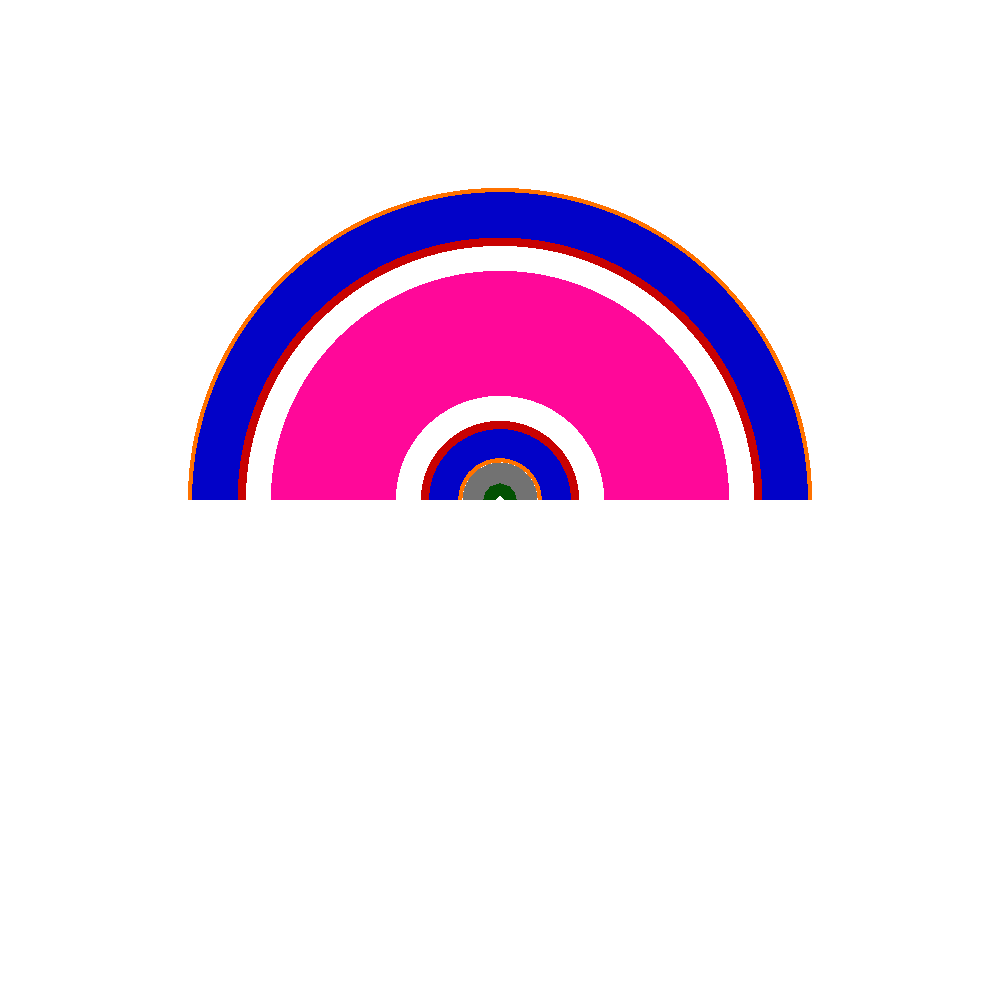

Displaying XZ (Cross-Section) View:


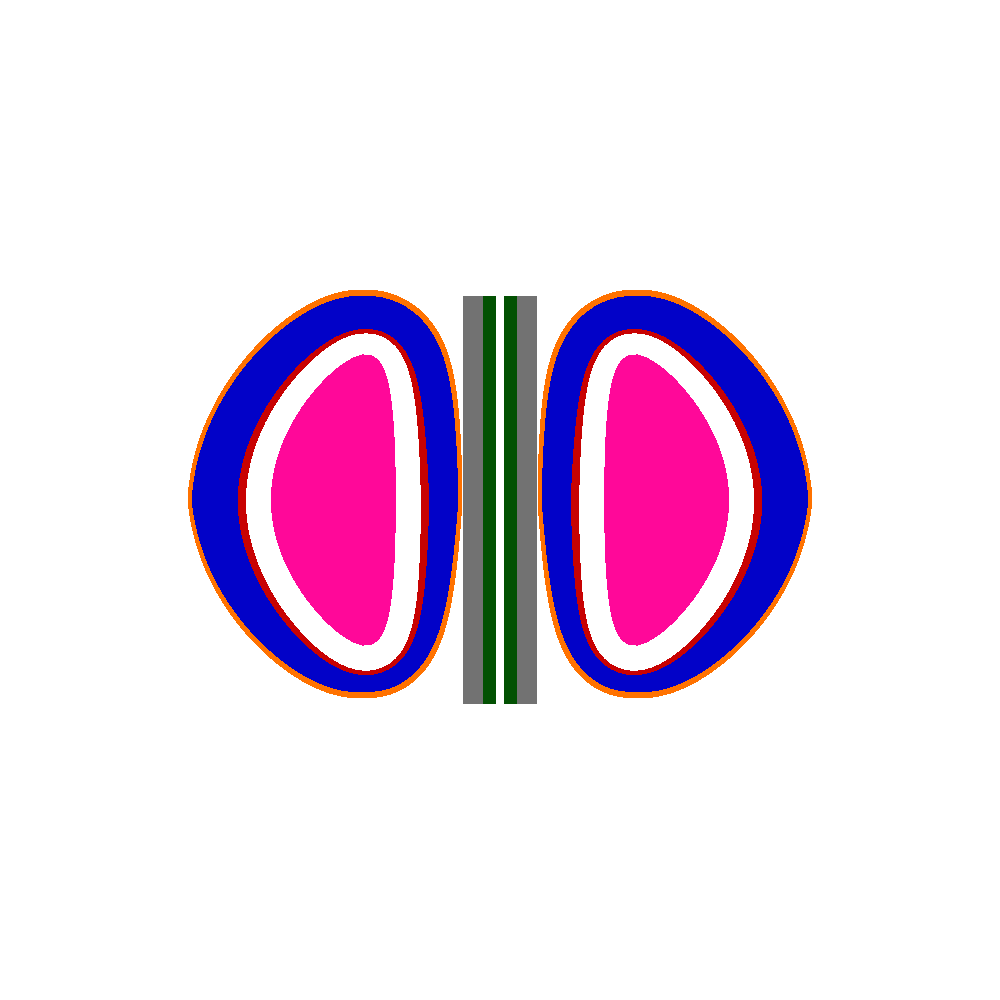

In [46]:
print("Creating geometry plots...")

# --- NEW (Corrected): Create color map by accessing sub-shape attributes ---
color_map = {}

for mat in materials_list:
    mat_name = mat.name  # e.g., 'layer_1', 'plasma', 'radial_layer_gap_1'

    paramak_color = None
    # Check if the reactor object has an attribute matching the material name
    if hasattr(my_reactor, mat_name):
        # Get the sub-shape object (e.g., my_reactor.plasma)
        shape_object = getattr(my_reactor, mat_name)

        # Get the .color attribute from that sub-shape
        if hasattr(shape_object, 'color'):
            paramak_color = shape_object.color # This is the cadquery.Color object
            print(paramak_color)
            print(type(paramak_color))

            # Optional: You can leave these debug prints in
            # print(f"Found color for {mat_name}: {paramak_color}")
            # print(f"Type is: {type(paramak_color)}")

    if paramak_color:
       # --- THIS IS THE CORRECTED BLOCK ---
        # paramak_color.wrapped is the OCP.OCP.Quantity.Quantity_ColorRGBA object
        rgba_color = paramak_color.wrapped

        # Get the internal Quantity_Color (RGB) object
        rgb_color = rgba_color.GetRGB()

        # Now get the R, G, B floats (0.0-1.0) from the Quantity_Color object
        openmc_color = (
            int(rgb_color.Red() * 255),
            int(rgb_color.Green() * 255),
            int(rgb_color.Blue() * 255)
        )
        # --- END OF FIX ---

        # Add to our map: {openmc.Material object: (R, G, B)}
        color_map[mat] = openmc_color
    else:
        # NOT FOUND. This is likely a 'gap' layer.
        # Assign a default color.
        if 'gap' in mat_name:
            color_map[mat] = (240, 240, 240) # Very Light Gray for Gaps
        else:
            color_map[mat] = (128, 128, 128) # Standard Gray for any other fallback


plot_xy = openmc.Plot()
plot_xy.filename = str(output_dir / 'reactor_plot_xy')
plot_xy.width = (max_boundary * 2, max_boundary * 2)
plot_xy.pixels = (1000, 1000)
plot_xy.basis = 'xy'
plot_xy.origin = (0, 0, 0)
plot_xy.color_by = 'material'
plot_xy.colors = color_map

plot_xz = openmc.Plot()
plot_xz.filename = str(output_dir / 'reactor_plot_xz')
plot_xz.width = (max_boundary * 2, max_boundary * 2)
plot_xz.pixels = (1000, 1000)
plot_xz.basis = 'xz'
plot_xz.origin = (0, 1, 0)
plot_xz.color_by = 'material'
plot_xz.colors = color_map

plots = openmc.Plots([plot_xy, plot_xz])

# --- NEW: Manually export the XMLs needed for plotting ---
print(f"Exporting XMLs to {output_dir} for plotting...")
my_materials.export_to_xml(path=str(output_dir / 'materials.xml'))
my_geometry.export_to_xml(path=str(output_dir / 'geometry.xml'))
# We don't need settings.xml for plotting

# Now, export the plots.xml
plots.export_to_xml(path=str(output_dir / 'plots.xml'))

# Run the plotting
openmc.plot_geometry(cwd=str(output_dir))
print(f"Plots created in {output_dir}")

# --- Display plots in the notebook ---
print("Displaying XY (Top-Down) View:")
display(Image(str(output_dir / 'reactor_plot_xy.png')))

print("Displaying XZ (Cross-Section) View:")
display(Image(str(output_dir / 'reactor_plot_xz.png')))

## Step 7: Run Simulation

In [16]:
print("Running OpenMC simulation...")
my_model = openmc.Model(
    geometry=my_geometry,
    materials=my_materials,
    settings=my_settings
)
model_path = my_model.run(cwd=str(output_dir))
print(f"Simulation run complete. Results in {model_path}")

Running OpenMC simulation...
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
         

In [17]:
print("\nWorkflow complete.")


Workflow complete.
